This notebook provides some examples on two-qubit tomography. 

## Initialization

### Imports

First, we'll do the meeded imports. Note that library's .py files are directly accessed from the folder `solver`.

In [1]:
from os import path
import warnings
assert path.exists("solver") 
assert path.exists("solver/utils") 

In [2]:
with warnings.catch_warnings():  # it still somehow pierces through
    import tensorflow as tf  # tf 2.x
import tensornetwork as tn
import numpy as np
import QGOpt as qgo
import math
import matplotlib.pyplot as plt

import solver.utils.general_utils as util
import solver.noising_tools as ns
import solver.utils.channel_utils as c_util
import solver.file_management as fm
import solver.circuits_generation as cg

from solver.QCCalc import QCEvaluator
from solver.experiments import ExperimentConductor, assert_psi2_eq_1
from solver.utils.misc import unwrap_dict, NconTemplate, INT, FLOAT, COMPLEX, ID_GATE
from solver.QCSolver import QGOptSolver, get_complex_channel_form, QGOptSolverDebug

tn.set_default_backend("tensorflow")

2022-04-29 22:34:57.070725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/qc7/.mujoco/mjpro150/bin
2022-04-29 22:34:57.070801: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-29 22:35:00.146447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/qc7/.mujoco/mjpro150/bin
2022-04-29 22:35:00.146521: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-29 22:35:00.146577: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (PeKa-II): /proc/driver

### Quantum gates preparation

Let us conduct a simple experiment which makes quantum tomography of gates $\sf RX$, $\sf RY$ and $\sf CX$. $\sf RX$ and $\sf RY$ represent unitary rotations with angle $\pi/2$, while $\sf CX$ represents the controlled NOT gate. These quantum gates can be expressed as unitary operators as follows:
$$
{\sf RX} =  \begin{bmatrix}
            \cos(\pi/4) & -\imath \sin(\pi/4)\\
            -\imath \sin(\pi/4) & \cos(\pi/4)
        \end{bmatrix},  
{\sf RY} =  \begin{bmatrix}
            \cos(\pi/4) & -\sin(\pi/4)\\
            \sin(\pi/4) & \cos(\pi/4)
        \end{bmatrix},
{\sf CX} =      
    \begin{bmatrix}
        1&0&0&0\\0&1&0&0\\0&0&0&1\\0&0&1&0
    \end{bmatrix}.
$$

We will also need an identity matrix: both for providiing a fictionary measurement gate (SPAM operation) and for internal purposes.

In [3]:
Rx = util.create_unitary_rotation_x(math.pi/2)
Ry = util.create_unitary_rotation_y(math.pi/2)
print('Rx:', Rx.numpy().round(3))
print('Ry:', Ry.numpy().round(3))

CX_44 = tf.constant([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0]], dtype=COMPLEX)

E = tf.eye(2, dtype=COMPLEX)

Rx: [[0.707+0.j    0.   -0.707j]
 [0.   -0.707j 0.707+0.j   ]]
Ry: [[ 0.707+0.j -0.707+0.j]
 [ 0.707+0.j  0.707+0.j]]


Now it is time to convert these unitary operators to quantum channels. Two-qubit gates need to be reshaped first.

In [4]:
CX = util.convert_44_to_2222(CX_44)

Rx_channel = c_util.convert_1qmatrix_to_channel(Rx)
Ry_channel = c_util.convert_1qmatrix_to_channel(Ry)
E_channel = c_util.convert_1qmatrix_to_channel(E)
CX_channel = c_util.convert_2qmatrix_to_channel(CX)

Now we need to make set of channels from this. The recommended order is to fill all single-qubit gates, then internal identity gate (**this is important**), then all two-qubit gates.

In [5]:
default_pure_channels = {'Rx':Rx_channel,
                         'Ry':Ry_channel,
                         'M': E_channel,
                         ID_GATE:E_channel,
                         'CX': CX_channel}                        

### Circuits preparation

We will need a `DataGenerator`, which can (surprisingly) generate quantum circuits, and convert quantum circuits to the tensor network template form. To initialize it, we need the gates' labels, and it's quite important to pass them in the same order as stated in `default_pure_channels` **without the internal `ID_GATE`**. Some day this inconvenient feature will be fixed. 

In [6]:
NUM_QUBITS = 2

gates_labels = list(default_pure_channels.keys())
gates_labels.remove(ID_GATE)

gen = cg.DataGenerator(qubits_num=NUM_QUBITS,
                       gates_names=gates_labels, # ['Rx', 'Ry', 'M', 'CX']
                       single_qub_gates_num=3,
                       two_qub_gates_num=1)

However, let's resort to using just the second option. We will not use any pre-made generators, but rather create the set of circuits ourselves. For simple tomography experiment, one can use different sets of:
* state preparation part
* middle part a. k. a. gates to be tomographied
* measurement gates part

TODO: explain why these sets are usually taken for tomography and how exactly they are conducted.

The quantum circuits is now defined as sequence of quantum gates applied to a different qubits. In the code, the so-called "human" quantum circuit is represented as a list of strings, with each string having format
'LABEL_TARGET' for single-qubit gates or 'LABEL_TARGET1_TARGET2' for two-qubit gates. The order of targets is important, and controlling qubit goes **first**.

We can write a simple function which generates a list of all available combinations. First, let's generate all circuits without CX gates in it:

In [7]:
def gen_circs_without_CX():
    preps = [[],
             ['Rx_0', 'Rx_1'],
             ['Ry_0', 'Ry_1'],
             ['Rx_0', 'Rx_0', 'Rx_1', 'Rx_1']]
    
    toms = [[],
            ['Rx_0', 'Rx_1'],
            ['Ry_0', 'Ry_1']]
    
    meass = [['M_0', 'M_1'],
             ['Rx_0', 'Rx_1', 'M_0', 'M_1'],
             ['Ry_0', 'Ry_1', 'M_0', 'M_1']]
    
    ans = []
    
    for prep in preps:
        for tom in toms:
            for meas in meass:
                ans.append(prep + tom + meas)
                
    return ans

circs1 = gen_circs_without_CX()

We can print these circuits represented by sequences of gates. Note that the labels of gates in string format are constistent with labels we gave in `default_pure_channels` dict as keys. 

In [8]:
np.random.seed(100)
print(default_pure_channels.keys())

for idx in np.random.choice(np.arange(len(circs1)), 3):
    print(f'Circuit #{idx} is represented as {circs1[idx]}')

dict_keys(['Rx', 'Ry', 'M', '_E', 'CX'])
Circuit #8 is represented as ['Ry_0', 'Ry_1', 'Ry_0', 'Ry_1', 'M_0', 'M_1']
Circuit #24 is represented as ['Ry_0', 'Ry_1', 'Ry_0', 'Ry_1', 'M_0', 'M_1']
Circuit #3 is represented as ['Rx_0', 'Rx_1', 'M_0', 'M_1']


Strings with CX gate between qubits 0 and 1 are made a little bit differently: the set of preparations and measurements is now extended (it allows asymmetric measuremetns), but now we have only one choice for middle part.

In [9]:
def gen_circs_with_CX():
    preps_0 = [[],
               ['Rx_0'],
               ['Ry_0'],
               ['Rx_0', 'Rx_0']]
    preps_1 = [[],
               ['Rx_1'],
               ['Ry_1'],
               ['Rx_1', 'Rx_1']]
    
    meas_0 = [['M_0'],
              ['Rx_0', 'M_0'],
              ['Ry_0', 'M_0']]
    meas_1 = [['M_1'],
              ['Rx_1', 'M_1'],
              ['Ry_1', 'M_1']]
    
    ans = []
    tup_ans = []
    
    for prep_0 in preps_0:
        for prep_1 in preps_1:
            for m_0 in meas_0:
                for m_1 in meas_1:
                    ans.append(prep_0 + prep_1 + ['CX_0_1'] + m_0 + m_1)
                
    return ans

circs2 = gen_circs_with_CX()

circs = circs1 + circs2
print(len(circs))

180


So far so good: we have just created 180 different circuits which allow for quantum gate tomography. We now need to convert it into tensor network templates format. Let's add an empty circuit for demonstration purposes:

In [10]:
np.random.seed(1337)

ncon_tmpls = gen.get_tmpl_dict_from_human_circs(circs + [[]])  # add an empty circuit

for idx in np.random.choice(np.arange(len(circs)), 3):
    print(f'A quantum circuit with very simple "human" representation \n{circs[idx]}'
    f'\nhas a very scary tensor network template \n{ncon_tmpls[str(idx)]}')

A quantum circuit with very simple "human" representation 
['Rx_0', 'Rx_0', 'CX_0_1', 'Ry_0', 'M_0', 'Rx_1', 'M_1']
has a very scary tensor network template 
[[0, 0, 7, 2, 4, 1, 5], [[3, 1], [4, 3], [6, 5, 2, 4], [7, 5], [-1, 7], [9, 6], [-2, 9]], [3, 4, 5, 6, 7, 9], [-1, -2]]
A quantum circuit with very simple "human" representation 
['Rx_0', 'Ry_1', 'CX_0_1', 'M_0', 'Ry_1', 'M_1']
has a very scary tensor network template 
[[0, 3, 7, 4, 3, 5], [[3, 1], [4, 2], [6, 5, 4, 3], [-1, 5], [8, 6], [-2, 8]], [3, 4, 5, 6, 8], [-1, -2]]
A quantum circuit with very simple "human" representation 
['Rx_0', 'Rx_0', 'Ry_1', 'CX_0_1', 'Rx_0', 'M_0', 'Ry_1', 'M_1']
has a very scary tensor network template 
[[0, 0, 3, 7, 0, 4, 3, 5], [[3, 1], [4, 3], [5, 2], [7, 6, 5, 4], [8, 6], [-1, 8], [10, 7], [-2, 10]], [3, 4, 5, 6, 7, 8, 10], [-1, -2]]


Right now we will not explain how these tensor network templates work. However, this form is widely used in the package `ncon`, and if you are familiar with it, you can read the tensor network templates just as "human" circuits.

In [11]:
print(list(ncon_tmpls.values())[-1])

[[6, 6], [[-1, 1], [-2, 2]], [], [-1, -2]]


Sometimes, your circuit will have no gates at certain qubits (or it may have no gates at all). DataGenerator notices that and contracts inputs with outputs using the special `ID_GATE` we passed above, which has the index of 6.

### Noising

The noise config may look quite complicated, but it's easier to grasp when you look closely at its element.
Element of a noise config is a tuple contaning
* label of a gate
* id of a gate; in a single-qubit case it coincides with qubit number and in two-qubit case it can be obtained by enumerating all qubit pairs. E. g. in three-qubit scenario, targer pairs `[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]` will be mapped to ids from 0 to 5.
* function to noise - it's best to use pre-defined function, which has four parameters
    * parameter for gaussian blur 
    * parameter for depolarization channel
    * parameter for amplitude damping
    * parameter for phase damping

TODO: tell about noise params more thoroughly.

In [12]:
noise_cfg = []

# comments are fidelities between noised and ideal versions of gate
noise_cfg.append(('Rx', 0, ns.make_1q_4pars_channel, 0.065, 0.03, 0.005, 0.005)) # 0.97135
noise_cfg.append(('Rx', 1, ns.make_1q_4pars_channel, 0.05, 0.03, 0.03, 0.0)) # 0.96153

noise_cfg.append(('Ry', 0, ns.make_1q_4pars_channel, 0.02, 0.02, 0.02, 0.02)) # 0.9701
noise_cfg.append(('Ry', 1, ns.make_1q_4pars_channel, 0.06, 0.01, 0.03, 0.03)) # 0.96826

noise_cfg.append(('M', 0, ns.make_1q_4pars_channel, 0.0, 0.04, 0.02, 0.02)) # 0.95567
noise_cfg.append(('M', 1, ns.make_1q_4pars_channel, 0.0, 0.03, 0.03, 0.03)) # 0.95583

noise_cfg.append(('CX', 0, ns.make_2q_4pars_channel, 0.05, 0.02, 0.02, 0.02)) # 0.93728

We can apply this noising function to a gate and see how it changes. For example, we may calculate fidelity between "pure" and "noised" quantum channels. Notice the small machine calculation error in imaginary part - we know that it should be equal to zero, but nothing is perfect. There are other metrics to compute (e. g. diamond norm). Since diamond norm is calculated via external Qiskit library, it already has quite beautiful output.

In [13]:
pure_channel = Rx_channel
noised_channel = ns.make_1q_4pars_channel(pure_channel, [0.05, 0.02, 0.02, 0.02])
print('Fidelity is', util.fidel_calc_1q(pure_channel, noised_channel).numpy())
print('Diamond norm is', util.diamond_norm_1q(pure_channel, noised_channel).numpy())

Fidelity is (0.9688945548090188+1.9075878905071783e-08j)
Diamond norm is 0.06466075373331996


In [14]:
pure_channel = CX_channel
noised_channel = ns.make_2q_4pars_channel(pure_channel, [0.05, 0.02, 0.02, 0.02])
print('Fidelity is', util.fidel_calc_2q(pure_channel, noised_channel).numpy())
print('Diamond norm is', util.diamond_norm_2q(pure_channel, noised_channel).numpy())

Fidelity is (0.9372799568088622+4.759170873593774e-18j)
Diamond norm is 0.13671446696269413


## Conducting experiment

We have a class called ExperimentConductor contaning all the parameters for our experiment. It has the:
* ideal gate set ${\bf G}^{\rm ideal}$
* noise configuration we have just made
* experiment name for working with files (more on that later)
* number of qubits
* learning rate
* regularization coefficients for one-qubit and two-qubit gates
* sample size a. k. a. shots number for sample generation (8192 is a realistic number you can get at real quantum PC)

Since we're not conducting any complicated experiments, the full functionality of this class will not be unleashed. However, it's convenient to store all the information together in order not to lose track. Notice the learning rate, regularizations and iterations hyperparameteres - they are all set here. These are not optimal but get the job done. Feel free to experiment!

In [15]:
with warnings.catch_warnings():
    exp_test = ExperimentConductor(pure_channels_set=default_pure_channels,
                                   noise_cfg=noise_cfg,
                                   exp_name='tomo_tutorial',
                                   qubits_num=NUM_QUBITS,
                                   lr=0.005,  
                                   lmbd1=100,
                                   lmbd2=100,
                                   iterations=300,
                                   sample_size=8192)

First, let's use solver as a sample generator in order to generate the outcomes for each circuit. Right now, the number of outcomes is shared across all circuits. We are using the debug version of QGOptSolver since it gives more info. Pay attention to the variable `noise_iter0` - it determines the initial approximation and it is is **SUPER** important for convergence to set this above zero in order not to get stuck in a local minima!

In [16]:
QC_t = QGOptSolverDebug(qubits_num=NUM_QUBITS,
                        single_qub_gates_names={'Rx', 'Ry', 'M'},
                        two_qub_gates_names={'CX'},
                        pure_channels_set=default_pure_channels,
                        compress_samples=True,
                        noise_params=exp_test.noise_params,
                        noise_iter0=0.07)

for name, tmpl in ncon_tmpls.items():
    QC_t.add_circuit(tn_template=tmpl, name=name)
    
QC_t.generate_all_samples(v=False, smpl_size=exp_test.sample_size)

generating samples... 25% 50% 75% Done!


Now we need to setup our manifold for quantum channels optimization and grab optimizer itself from `QGOpt` library.

In [17]:
manif = qgo.manifolds.ChoiMatrix()
opt_t = qgo.optimizers.RAdam(manif, exp_test.lr)

We are ready to minimize the loss hard-coded in the solver:   
TODO: talk about loss.  
See article for details.  

In [18]:
loss_dynamics_t, norms_dict, _ = QC_t.train_optimizer(opt=opt_t,
                                                     lmbd1=exp_test.lmbd1,
                                                     lmbd2=exp_test.lmbd2,
                                                     iters=exp_test.iters,
                                                     v=1,
                                                     fid_ctr=1, # we'd like to calculate fidelities every step
                                                     norm_ctr=-1)  # we don't calculate L1 norms here

0 out of 300 iterations passed
30 out of 300 iterations passed
60 out of 300 iterations passed
90 out of 300 iterations passed
120 out of 300 iterations passed
150 out of 300 iterations passed
180 out of 300 iterations passed
210 out of 300 iterations passed
240 out of 300 iterations passed
270 out of 300 iterations passed


We can look at our loss dymamics to see that learning process was OK:

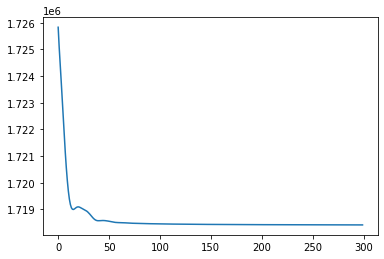

In [19]:
plt.plot(loss_dynamics_t)  

## Results

**TBD: Rewrite this section better**.
Because we used the Debug version of the solver, it has the ability to extract norms of all estimated gates ${\bf G}^{\rm est}$ during each iteration of algorithm. For measurement gate ${\sf M}$, POVM norm is extracted instead.

Let's plot these norms to prove that our algorithm did a good job. Since we were the ones who generated the noise, we have such information; of course, in real experiment we would be able to see only norms between ideal and estimated versions. First, we extract the `true` norms which will appear in our graph as horizontal lines:

In [20]:
from collections import defaultdict
HLINES = defaultdict(list)

for label in QC_t.hidden_gates_dict:
    sublist = QC_t.hidden_gates_dict[label]
    for idx, gate in enumerate(sublist):
        if label == 'CX':
            HLINES[label].append(util.diamond_norm_2q(gate, default_pure_channels[label]))
        elif label == 'M':
            HLINES[label].append(util.get_povm_dist(gate, default_pure_channels[label]))
        else:
            HLINES[label].append(util.diamond_norm_1q(gate, default_pure_channels[label]))
            
COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:gray']

### Plotting norms

In [27]:
def plot_diamond_norms(ax1, ax2):
    colors_idx = [0, 0]
    
    for key in norms_dict.keys():
        label, idx, norm_type = key

        if label in ['Rx', 'Ry', 'CX']:
            if label == 'CX' and idx == 1:
                continue
                
            if norm_type == 'i':
                ax1.plot(np.abs(norms_dict[label, idx, norm_type]),
                         label=f'{label}{idx}',
                         color=COLORS[colors_idx[0]])
                ax1.axhline(y=HLINES[label][idx],
                            color=COLORS[colors_idx[0]],
                            linestyle=':')
                colors_idx[0] += 1

            else:
                ax2.plot(np.abs(norms_dict[label, idx, norm_type]),
                         label=f'{label}{idx}',
                         color=COLORS[colors_idx[1]])
                colors_idx[1] += 1
            
    ax1.set_title('Diamond norm(ideal, est)', {"size":18})
    ax1.set_xlabel('Algorithm iteration number', {"size":16})

    ax2.set_title('Diamond norm(true, est)', {"size":18})
    ax2.set_xlabel('Algorithm iteration number', {"size":16})

    ax1.legend(prop={'size': 14})
    ax2.legend(prop={'size': 14})
        
        # ax.set_ylim(0.92, 0.98)

In [28]:
def plot_povm_norms(ax1, ax2):
    colors_idx = [0, 0]
    
    for key in norms_dict.keys():
        label, idx, norm_type = key

        if label == 'M':
            if norm_type == 'i':
                ax1.plot(np.abs(norms_dict[label, idx, norm_type]),
                         label=f'{label}{idx}',
                         color=COLORS[colors_idx[0]])
                ax1.axhline(y=HLINES[label][idx],
                            color=COLORS[colors_idx[0]],
                            linestyle=':')
                colors_idx[0] += 1

            else:
                ax2.plot(np.abs(norms_dict[label, idx, norm_type]),
                         label=f'{label}{idx}',
                         color=COLORS[colors_idx[1]])
                colors_idx[1] += 1
            
    ax1.set_title('POVM norm(ideal, est)', {"size":18})
    ax1.set_xlabel('Algorithm iteration number', {"size":16})

    ax2.set_title('POVM norm(true, est)', {"size":18})
    ax2.set_xlabel('Algorithm iteration number', {"size":16})

    ax1.legend(prop={'size': 14})
    ax2.legend(prop={'size': 14})
        
        # ax.set_ylim(0.92, 0.98)

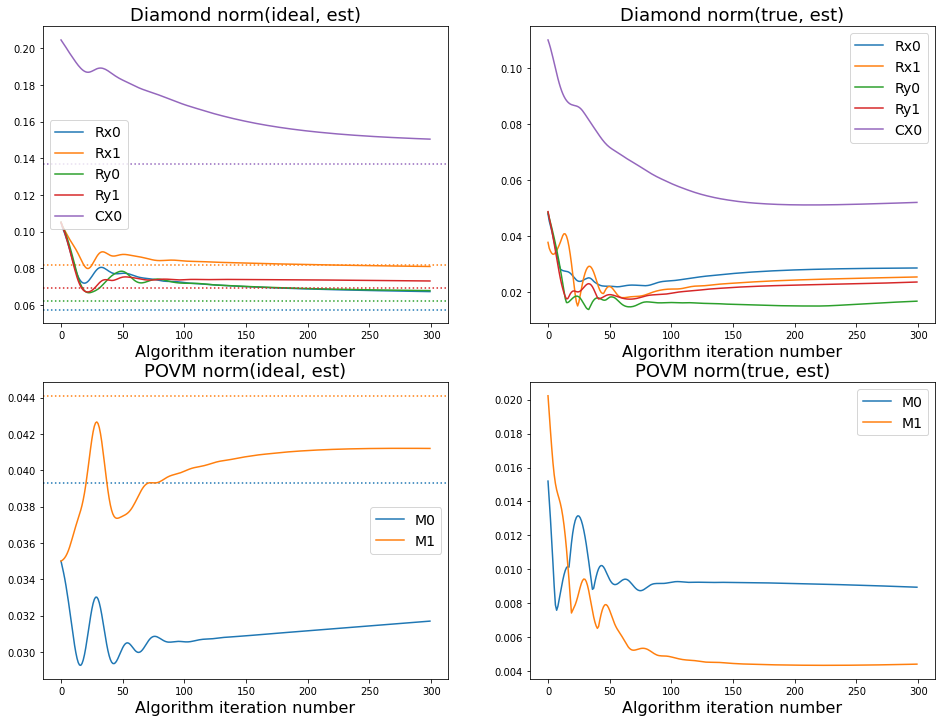

In [29]:
fig, axarr = plt.subplots(2, 2, figsize=(16, 12))
ax1, ax2, ax3, ax4 = [a for sublist in axarr for a in sublist]
plot_diamond_norms(ax1, ax2)
plot_povm_norms(ax3, ax4)

As you can see, our alrogithm achieved success using 180 circuits w

### Saving and loading data

**TBD**